In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA

In [2]:
from soap import *

In [3]:
_, structure, species = read_cif("CIF_files/DB0-m1_o14_smb_repeat.cif")

In [4]:
soap_out = S(structure = structure, species = species)

In [6]:
soap_out.shape

(213, 20)

In [7]:
N_env, N_feat = soap_out.shape

In [11]:
# 1) Build the N_env × N_env kernel among environments.  
#    For example, use an RBF kernel with some gamma > 0.
def rbf_kernel(u, v, gamma=1e-3):
    diff = u - v
    return np.exp(-gamma * (diff @ diff))

K = np.zeros((N_env, N_env))
for i in range(N_env):
    for j in range(N_env):
        K[i, j] = rbf_kernel(soap_out[i], soap_out[j], gamma=1e-3)

eigvals, eigvecs = np.linalg.eigh(K)
alpha = eigvecs[:, -1]       # shape = (N_env,)
# (Optionally, you can normalize alpha so that sum(alpha^2)=1 or so that sum(alpha)=1, etc.)
alpha = alpha / np.linalg.norm(alpha)

# --- 3) Form the weighted‐sum row d = alpha^T @ soap_out ---
d = alpha.reshape(1, N_env) @ soap_out   # shape = (1, N_feat)

print("collapsed descriptor shape:", d.shape)

collapsed descriptor shape: (1, 20)


In [17]:
d[0]

array([-4.29396800e+01, -7.76591118e-01, -6.10796517e+01,  7.41633485e-01,
       -2.48782458e+00,  4.41300806e-02, -1.50099893e-01,  2.19073161e-02,
       -2.05581195e+02, -4.83435708e+00, -2.37979335e+01,  2.37159273e-01,
       -1.81910368e+00,  2.03033009e-01, -2.98549818e+01, -3.40070064e-01,
       -7.09092416e+00, -4.51915788e-02, -6.53136502e+00, -1.20871675e-01])

In [21]:
si = S(structure = structure, species = species, average = "inner")

In [22]:
si

array([ 1.52091564e+00,  4.50189564e-05,  4.16378818e+00, -2.95287154e-05,
        1.03914068e+00,  2.32330997e-06,  2.98309005e-01, -1.78135509e-05,
        1.13991411e+01,  4.20726344e-05,  2.84484003e+00, -2.26701741e-05,
        8.16676138e-01,  1.01262552e-05,  7.09975838e-01,  2.98115188e-05,
        2.03814738e-01, -9.46465465e-06,  5.85096637e-02,  1.71519504e-05])

In [23]:
so = S(structure = structure, species = species, average = "outer")

In [24]:
so

array([ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00, -5.19847926e-02,
        1.63876232e-01, -2.68026443e-03,  9.99165625e-03, -1.45617068e-03,
        1.54767122e+01,  3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
        1.21731496e-01, -1.35054514e-02,  1.99147215e+00,  2.26188261e-02,
        4.92624250e-01,  2.93805103e-03,  4.62426975e-01,  8.11873260e-03])

In [20]:
import numpy as np
import matplotlib.pyplot as plt

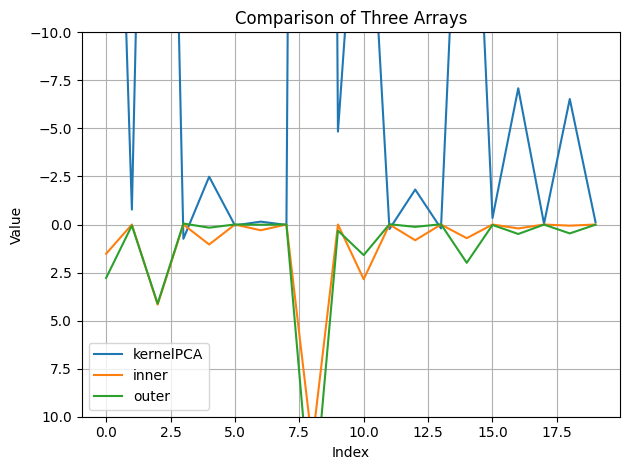

In [32]:
plt.plot(np.arange(20), d[0], label='kernelPCA')
plt.plot(np.arange(20), si, label='inner')
plt.plot(np.arange(20), so, label='outer')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Three Arrays')
plt.legend()
plt.ylim(10,-10)
plt.grid()
plt.tight_layout()
plt.show()

# ML

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.neural_network import MLPRegressor


In [34]:
# Read feature descriptors
X = pd.read_csv('kernelPCA_soap_mofs.csv')

# Read labels
y = pd.read_csv('id_labels.csv')


In [35]:
print(X.shape)
print(y.shape)

(3089, 551)
(3089, 2)


In [36]:
X['filename'] = X['filename'].str.replace('.cif', ' ', regex=False)

In [37]:
X.head()

,V-V_1,V-V_2,V-H_1,V-H_2,V-C_1,V-C_2,V-O_1,V-O_2,H-H_1,H-H_2,...,Dy-Dy_1,Dy-Dy_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Co-Br_1,Co-Br_2,F-Ti_1,F-Ti_2
0,9.913646,0.219398,12.334559,-0.045885,0.336669,0.000244,0.010825,-0.00259,56.320046,1.095121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-87.928944,-1.807842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,81.257427,1.909476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-133.613587,-3.162749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,74.262139,1.782071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
y.head()

,id,label
0,DB5-hypotheticalMOF_17652_0_0_1_21_9_7_repeat,13.791591
1,DB0-m2_o8_o23_f0_pcu.sym.80_repeat,3.786996
2,DB0-m29_o90_o1500_f0_pts.sym.31_repeat,9.382537
3,DB0-m3_o48_o25_f0_fsc.sym.3_repeat,11.650365
4,DB0-m2_o1_o9_f0_nbo.sym.104_repeat,1.412915


In [39]:
X.set_index('filename', inplace = True)

In [40]:
y.set_index('id', inplace = True)

In [41]:
X.sort_index(inplace=True)

In [42]:
y.sort_index(inplace=True)

In [43]:
print("Are they exactly equal?", (X.index == y.index).all())

Are they exactly equal? True


In [44]:
X

,V-V_1,V-V_2,V-H_1,V-H_2,V-C_1,V-C_2,V-O_1,V-O_2,H-H_1,H-H_2,...,Dy-Dy_1,Dy-Dy_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Co-Br_1,Co-Br_2,F-Ti_1,F-Ti_2
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m12_o14_bcu_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.297930,0.429321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m12_o8_o32_tfz-d_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.811569,0.672671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o11_o140_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.406009,0.000301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o14_o137_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.679638,-0.008051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o15_o48_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.543582,-0.011597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-283.795255,-5.487907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5786_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.732321,-0.176023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5952_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-21.302741,-0.259695,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.225474,0.001811,0.0,0.0


In [45]:
y

,label
id,
DB0-m12_o14_bcu_repeat,16.427428
DB0-m12_o8_o32_tfz-d_repeat,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,5.446165
...,...
DB7-ddmof_5561_repeat,4.954847
DB7-ddmof_5786_repeat,5.020765
DB7-ddmof_5952_repeat,6.185781


In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [47]:
X

,V-V_1,V-V_2,V-H_1,V-H_2,V-C_1,V-C_2,V-O_1,V-O_2,H-H_1,H-H_2,...,Dy-Dy_1,Dy-Dy_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Co-Br_1,Co-Br_2,F-Ti_1,F-Ti_2
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m12_o14_bcu_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.297930,0.429321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m12_o8_o32_tfz-d_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.811569,0.672671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o11_o140_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.406009,0.000301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o14_o137_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.679638,-0.008051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o15_o48_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.543582,-0.011597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-283.795255,-5.487907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5786_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.732321,-0.176023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5952_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-21.302741,-0.259695,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.225474,0.001811,0.0,0.0


In [48]:
# Step 1: Scale X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 3: Train linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict
y_pred = model.predict(X_test)

# Step 5: Evaluate
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 195745064450415.75
R² Score: -6.510497140613689e+26


In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)



/home/mmm9886/.conda/envs/pyemma/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [50]:
# Evaluate
print("Random Forest RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 3.8735123344145075
Random Forest R²: 0.7450574074114302


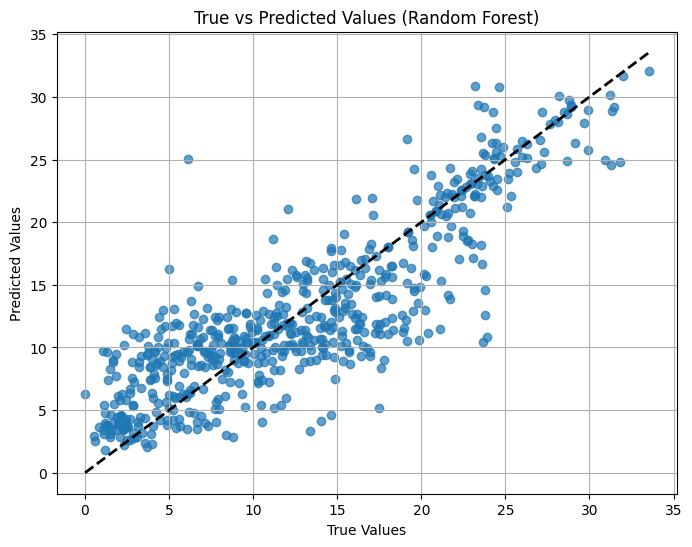

In [51]:
# Make a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)

# Plot a diagonal reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Labels
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (Random Forest)')
plt.grid(True)
plt.show()

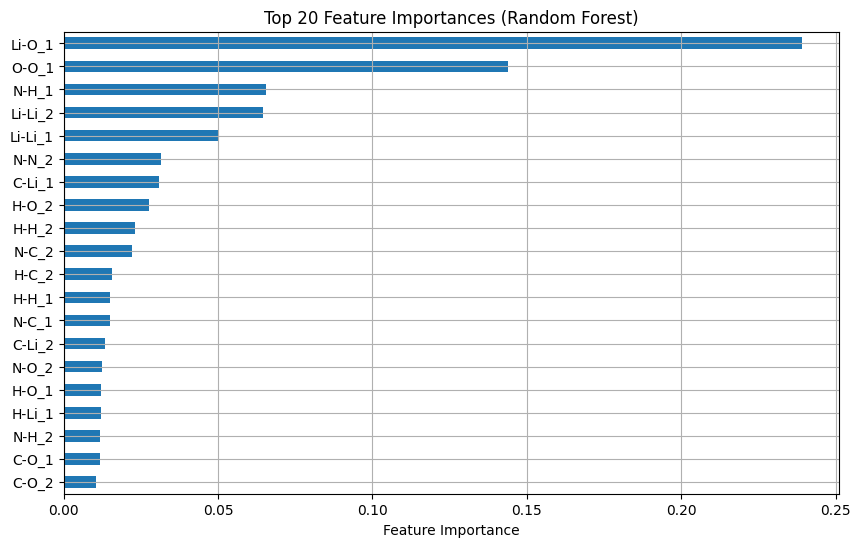

In [52]:
# 1. Get feature importances
importances = rf.feature_importances_

# 2. Map them to feature names
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# 3. Sort them descending
feature_importances = feature_importances.sort_values(ascending=False)

# 4. Plot the top N features
top_n = 20  # you can change to top 10, 20, etc.

plt.figure(figsize=(10, 6))
feature_importances[:top_n].plot(kind='barh')
plt.gca().invert_yaxis()  # Highest importance at top
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.grid(True)
plt.show()

In [53]:
from pycaret.regression import *

In [54]:
y

,label
id,
DB0-m12_o14_bcu_repeat,16.427428
DB0-m12_o8_o32_tfz-d_repeat,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,5.446165
...,...
DB7-ddmof_5561_repeat,4.954847
DB7-ddmof_5786_repeat,5.020765
DB7-ddmof_5952_repeat,6.185781


In [55]:
data = pd.concat([X, y], axis = 1)

In [56]:
data

,V-V_1,V-V_2,V-H_1,V-H_2,V-C_1,V-C_2,V-O_1,V-O_2,H-H_1,H-H_2,...,Dy-Dy_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Co-Br_1,Co-Br_2,F-Ti_1,F-Ti_2,label
DB0-m12_o14_bcu_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.297930,0.429321,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,16.427428
DB0-m12_o8_o32_tfz-d_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.811569,0.672671,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.406009,0.000301,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.679638,-0.008051,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.543582,-0.011597,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.446165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-283.795255,-5.487907,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,4.954847
DB7-ddmof_5786_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.732321,-0.176023,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.020765
DB7-ddmof_5952_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-21.302741,-0.259695,...,0.0,0.0,0.0,0.0,0.0,-0.225474,0.001811,0.0,0.0,6.185781
DB7-ddmof_6321_repeat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.244494,0.366992,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,3.526927


In [57]:
exp1 = setup(data, target='label', session_id=123)

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Regression
3,Original data shape,"(3089, 551)"
4,Transformed data shape,"(3089, 551)"
5,Transformed train set shape,"(2162, 551)"
6,Transformed test set shape,"(927, 551)"
7,Numeric features,550
8,Preprocess,True
9,Imputation type,simple


In [58]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.9702,15.4297,3.9244,0.7468,0.4159,1.1637,0.7760
rf,Random Forest Regressor,3.0210,15.6054,3.9460,0.7439,0.4153,0.8817,1.0720
lightgbm,Light Gradient Boosting Machine,3.0931,16.3598,4.0407,0.7311,0.4278,0.9702,49.9400
xgboost,Extreme Gradient Boosting,3.2159,17.7555,4.2084,0.7096,0.4493,1.5162,0.2280
gbr,Gradient Boosting Regressor,3.4711,18.3562,4.2823,0.6989,0.4530,1.1539,0.4220
ada,AdaBoost Regressor,4.3885,27.0003,5.1954,0.5565,0.5593,1.5055,0.1570
knn,K Neighbors Regressor,4.0117,28.2958,5.3146,0.5354,0.5285,1.6908,0.0590
dt,Decision Tree Regressor,3.8995,28.5173,5.3279,0.5331,0.5473,0.8900,0.0820
br,Bayesian Ridge,6.0297,54.1883,7.3543,0.1162,0.6851,2.1327,0.0720
en,Elastic Net,6.0163,54.2602,7.3587,0.1152,0.6842,2.1139,0.0540
